# 0. Library Import

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import time
import cv2
import random
import gc
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import SimpleITK as sitk
import pydicom as dcm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import *
from torchvision.transforms import Compose

from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
CFG={'Image_Size':256,
    'EPOCHS':100,
    'BATCH_SIZE':8,
    'Learning_rate':1e-3,
    'beta_1':0.9,
    'beta_2':0.99,
    'eps':0.00000001,
     'weight_decay':0.000001,
    'Channel_size':8,
    'SEED':42}

Number_of_aug=3

In [3]:
warnings.filterwarnings('ignore')

# 1. Check Gpu Server

In [4]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
    
print(f"device  : {device}")

device  : cuda


In [5]:
print(f"Name of the graphic card : {torch.cuda.get_device_name(0)}")
print(f"Number of gpu : {torch.cuda.device_count()}")

Name of the graphic card : NVIDIA GeForce RTX 4090
Number of gpu : 2


### Make Trash can

In [6]:
gc.collect()
torch.cuda.empty_cache()

### Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(CFG['SEED'])

# 2. Get Data Path

In [8]:
path='C:\\Users\\PC00\\Desktop\\ASD_data\\imaging_name.xlsx'

In [9]:
info_asd=pd.read_excel(path, sheet_name='ASD')
info_control=pd.read_excel(path, sheet_name='TC')

In [10]:
info_asd.head()

,Folder,DTI,DTI_N,T1,T1_N,T2,T2_N,age,sex
0,3564,Axi DTi 147 2.4mm,9472,GE Sag T1 MPRAGE 1000/900,160,Axi T2 Cube Reformat,174,3.833333,1
1,3278,Axi DTI +6 Dir 2.4mm,448,Sag FSPGR BRAVO,164,Axi T2 Reformat,165,5.416667,1
2,3395,Axi DTi 147 2.4mm,9472,GE Sag T1 MPRAGE 10,164,Axi T2 Cube Reformat,165,3.916667,1
3,3466,Axi DTi 147 2.4mm,9472,GE Sag T1 MPRAGE 10,152,Axi T2 Cube Reformat,164,3.666667,2
4,3624,Axi DTi 147 2.4mm,9472,GE Sag T1 MPRAGE 10,164,Axi T2 Cube Reformat,159,3.666667,1


In [11]:
info_control.head()

,Folder,DTI,DTI_N,T1,T1_N,T2,T2_N,age,sex
0,5945,Axi DTI 30Dir,2574,Sag FSPGR BRAVO HS,164,Ax T2 FSE PRO,32,5.916667,1
1,3979,Axi DTI 30Dir,2508,Sag FSPGR BRAVO,148,Ax T2 FSE PRO,32,5.916667,2
2,3650,Axi DTI 30Dir,2442,Sag FSPGR BRAVO,148,Ax T2 FSE PRO,30,5.916667,1
3,4629,Ax DTI 30 Hyperband,2304,Sag FSPGR BRAVO,144,Ax T2 FSE PRO,30,5.916667,1
4,s4-102,Axi DTI 25 Dir,650,FL:A/PU:Ax FSPGR BRAVO,152,LF:A/PU:Ax T2 FSE(ok),25,5.916667,1


In [12]:
age_3_asd=[]

for index, a in enumerate(info_asd['age'].values):
    if a>=3:
        print(f"index : {info_asd['Folder'].values[index]}, a : {a}")
        age_3_asd.append(info_asd['Folder'].values[index])
        
print(len(age_3_asd))

index : 3564, a : 3.8333333333333335
index : 3278, a : 5.416666666666667
index : 3395, a : 3.9166666666666665
index : 3466, a : 3.6666666666666665
index : 3624, a : 3.6666666666666665
index : 4881, a : 5.75
index : 4047, a : 5.083333333333333
index : 4586, a : 4.416666666666667
index : 4859, a : 3.0
index : 5023, a : 5.583333333333333
index : 4224, a : 3.4166666666666665
index : 3009, a : 3.1666666666666665
index : 4827, a : 4.583333333333333
index : 4837, a : 3.25
index : 3519, a : 5.333333333333333
index : 4916, a : 5.166666666666667
index : 4259, a : 4.833333333333333
index : 5253, a : 4.666666666666667
index : 5345, a : 4.333333333333333
index : 3685, a : 4.0
index : 4618, a : 3.9166666666666665
index : 5102, a : 3.75
index : 4044, a : 3.4166666666666665
index : 4043, a : 3.3333333333333335
index : 4600, a : 3.1666666666666665
index : 4997, a : 3.0833333333333335
index : 5129, a : 3.9166666666666665
index : 1543, a : 4.166666666666667
index : 3488, a : 5.916666666666667
index : 320

In [13]:
age_3_control=[]

for index, a in enumerate(info_control['age'].values):
    if a>=3:
        print(f"index : {info_control['Folder'].values[index]}, a : {a}")
        age_3_control.append(info_control['Folder'].values[index])
        
print(len(age_3_control))

index : 5945, a : 5.916666666666667
index : 3979, a : 5.916666666666667
index : 3650, a : 5.916666666666667
index : 4629, a : 5.916666666666667
index : s4-102, a : 5.916666666666667
index : 5776, a : 5.833333333333333
index : 5933, a : 5.833333333333333
index : s4-98, a : 5.833333333333333
index : 2235, a : 5.833333333333333
index : 4582, a : 5.75
index : 569, a : 5.75
index : 3390, a : 5.75
index : 4623, a : 5.666666666666667
index : 3834, a : 5.666666666666667
index : 4931, a : 5.583333333333333
index : 5190, a : 5.583333333333333
index : 1825, a : 5.583333333333333
index : 1928, a : 5.583333333333333
index : 638, a : 5.583333333333333
index : 4808, a : 5.5
index : 4329, a : 5.5
index : 3864, a : 5.416666666666667
index : 1084, a : 5.416666666666667
index : 2027, a : 5.416666666666667
index : 5660, a : 5.333333333333333
index : 3520, a : 5.333333333333333
index : 4371, a : 5.333333333333333
index : 2917, a : 5.25
index : s4-326, a : 5.166666666666667
index : 4803, a : 5.0833333333333

In [14]:
path_asd='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\'
path_control='C:\\Users\\PC00\\Desktop\\ASD_data\\CONTROL\\'

test_asd=[537,571,1856,2071,2126,2886,2922,3207,3488,3519,3565,4026,4047,4109,4270,4355,4396,4681,4740,4806,4881,4887,4916,5023,'s4-107']
test_control=[569,638,1825,1928,2235,3390,3650,3834,3979,4582,4623,4629,4931,5190,5776,5933,5945,'s4-98','s4-102']

asd_p=os.listdir(path_asd)
control_p=os.listdir(path_control)

#age_3_asd, age_3_control

#MRI_image=['MAGIC_T2']
all_image_path=[]

for name in asd_p:
    path=path_asd+name+'\\'+'aNew'+'\\'+'MAGIC_T2'+'\\'
    n=name.split('_')[0]
    if 'Test' in path or '3564' in path or '3278' in path or '3395' in path or '3466' in path or '3624' in path or '3603' in path or '3632' in path or '3663' in path:
        pass
    else:
        try:      
            n=int(n)
            if n in test_asd:
                pass
            elif n in age_3_asd:
                all_image_path.append(path)
        except:
            if n in test_asd:
                pass
            elif n in age_3_asd:
                all_image_path.append(path)

asd=len(all_image_path)
print("ASD Image Data : " , asd)

for name in control_p:
    path=path_control+name+'\\'+'aNew'+'\\'+'MAGIC_T2'+'\\'
    n=name.split('_')[0]
    if 'Test' in path or '3564' in path or '3278' in path or '3395' in path or '3466' in path or '3624' in path or '3603' in path or '3632' in path or '3663' in path:
        pass
    elif n in test_control:
        pass
    else:
        try:      
            n=int(n)
            if n in test_control:
                pass
            elif n in age_3_control:
                all_image_path.append(path)
        except:
            if n in test_control:
                pass
            elif n in age_3_control:
                all_image_path.append(path)

print("TC Image Data : ", len(all_image_path)-asd)
print("ASD+TC Image Data : " ,len(all_image_path))

ASD Image Data :  124
TC Image Data :  44
ASD+TC Image Data :  168


In [15]:
for info in all_image_path:
    print(info)    

C:\Users\PC00\Desktop\ASD_data\ASD\1111_KJW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1113_LJH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1321_KSH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1543_BYS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1659_YHS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1692_CMK\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1734_PJW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1736_KSJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1751_CYS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1787_CWJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1820_PSY\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1888_ASY\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1914_KMS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2026_CJW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2054_LKH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2261_KKB\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2262_ASY\aNew\MAGIC_T

# 3. Make Label

In [16]:
label=np.array([1]*asd+[0]*(len(all_image_path)-asd), dtype=np.int64)

In [17]:
print(len(label))

168


In [18]:
n=np.unique(label, axis=0)
n=n.shape[0]

label=np.eye(n)[label]
print(n)

2


In [19]:
label

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

# 4. Divide Data path

#### Test

In [20]:
test_asd=[537,571,1856,2071,2126,2886,2922,3207,3488,3519,3565,4026,4047,4109,4270,4355,4396,4681,4740,4806,4881,4887,4916,5023,'s4-107']
test_control=[569,638,1825,1928,2235,3390,3650,3834,3979,4582,4623,4629,4931,5190,5776,5933,5945,'s4-98','s4-102']
#MRI_image=['SPGR_P','MAGIC_T2']

test_image_path=[]

for name in asd_p:
    path=path_asd+name+'\\'+'aNew'+'\\'+'MAGIC_T2'+'\\'
    n=name.split('_')[0]
    try:      
        n=int(n)
        if n in test_asd:
            test_image_path.append(path)
    except:
        if n in test_asd:
            test_image_path.append(path)

tasd=len(test_image_path)
print("Test ASD Image Data : " , len(test_image_path)) 

for name in control_p:
    path=path_control+name+'\\'+'aNew'+'\\'+'MAGIC_T2'+'\\'
    n=name.split('_')[0]
    try:      
        n=int(n)
        if n in test_control:
            test_image_path.append(path)
    except:
        if n in test_control:
            test_image_path.append(path)

print("Test TC Image Data : ", len(test_image_path)-tasd)
print("Test ASD+TC Image Data : " ,len(test_image_path))

Test ASD Image Data :  25
Test TC Image Data :  19
Test ASD+TC Image Data :  44


In [21]:
for p in test_image_path:
    print(p)

C:\Users\PC00\Desktop\ASD_data\ASD\1856_CJW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2071_LWH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2126_SES\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2886_LSM\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\2922_JJW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\3207_KHK\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\3488_KSW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\3519_SMK\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\3565_LYR\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4026_KBM\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4047_JKH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4109_UDM\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4270_CAI\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4355_YJH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4396_KDW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4681_PSH_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\4740_KDH\aNew\MAGI

In [22]:
test_label=np.array([1]*tasd+[0]*(len(test_image_path)-tasd), dtype=np.int64)

In [23]:
print(len(test_label))

44


In [24]:
n=np.unique(test_label, axis=0)
n=n.shape[0]

test_label=np.eye(n)[test_label]
print(n)

2


In [25]:
test_label

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

#### Train and Val

Train : Val = 0.8 : 0.2

In [26]:
train_path, val_path, train_label, val_label=train_test_split(all_image_path, label, test_size=0.3, random_state=CFG['SEED'])

In [27]:
print(len(train_path), len(val_path), len(train_label), len(val_label))

117 51 117 51


##### For augmentation, call TC path twice

In [28]:
#train_path중 TC만 살짝 빼기
aug_image_path=[]

for p in train_path:
    if 'CONTROL' in p:
        aug_image_path.append(p)
        
print(len(aug_image_path))

31


In [29]:
#val_path중 TC만 살짝 빼기
sample_vtc=[]

for p in val_path:
    if 'CONTROL' in p:
        sample_vtc.append(p)
        
print(len(sample_vtc))

13


In [30]:
aug_label=np.array([1,0]*(len(aug_image_path)) ,dtype=np.float64)
aug_label=np.reshape(aug_label, (-1, 2))

In [31]:
len(aug_label)

31

In [32]:
aug_label

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [33]:
train_asd=0
train_tc=0
for path in train_path:
    if 'CONTROL' in path:
        train_tc+=1
    
train_asd=len(train_path)-train_tc      
print("Train ASD : ", train_asd)
print("Train TC : ", train_tc+(train_tc*Number_of_aug))

Train ASD :  86
Train TC :  124


In [34]:
val_asd=0
val_tc=0
for path in val_path:
    if 'CONTROL' in path:
        val_tc+=1
    
val_asd=len(val_path)-val_tc      
print("Val ASD : ", val_asd)
print("Val TC : ", val_tc)

Val ASD :  38
Val TC :  13


# 5. Transform and augmentation

## Transform

### Resize

In [35]:
pad_image=[[0]*256]*256

In [36]:
def T1_resize(img_volume, plus_image):
    #(256, 256, 188)
    
    want_channel=188
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    #차이가 짝수이면
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

In [37]:
def T2_resize(img_volume, plus_image):
    #(256, 256, 34)
    
    want_channel=34
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        #차이가 짝수이면
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

### cropping

In [38]:
def T1_crop(img_volume):
    area=(45, 45, 215, 215)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i]
    
        img=Image.fromarray(np.uint16(img))

        img=img.crop(area)
        
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

In [39]:
def T2_crop(img_volume):
    area=(40, 40, 225, 225)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i]
    
        img=Image.fromarray(np.uint16(img))

        img=img.crop(area)
        
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

### MinMaxScaler

In [40]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X,y=None):
        x=np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [41]:
scaler = MinMaxScaler3D()

## Augmentation

#### horizontal flip

In [42]:
def horizontal_flip(img_volume):
    s=torchvision.transforms.functional.hflip(torch.Tensor(img_volume))
    return np.array(s)

#### vertical flip

In [43]:
def vertical_flip(img_volume):
    s=torchvision.transforms.functional.vflip(torch.Tensor(img_volume))
    return np.array(s)

#### rotate

In [44]:
def rotate(img_volume, angle):
    s=torchvision.transforms.functional.rotate(torch.Tensor(img_volume), angle)
    return np.array(s)

#### example

In [45]:
a=np.random.randint(0,len(aug_image_path))
print(a)

6


original

In [46]:
img1=get_image(aug_image_path[a])
print(img1.shape)
plt.figure(figsize=(40,40))

for h in range(1,34):
    plt.subplot(5,34//5+1,h)
    plt.imshow(img1[h])
    plt.axis('off')
    
plt.savefig('T2_original.png')

NameError: name 'get_image' is not defined

horizontal

In [47]:
img2=horizontal_flip(img1)
print(img2.shape)
plt.figure(figsize=(40,40))

for h in range(1,34):
    plt.subplot(5,34//5+1,h)
    plt.imshow(img2[h])
    plt.axis('off')
    
plt.savefig('T2_horizontal.png')

NameError: name 'img1' is not defined

vertical

In [48]:
img3=vertical_flip(img1)
print(img3.shape)
plt.figure(figsize=(40,40))

for h in range(1,34):
    plt.subplot(5,34//5+1,h)
    plt.imshow(img3[h])
    plt.axis('off')
    
plt.savefig('T2_vertical.png')

NameError: name 'img1' is not defined

rotate

In [49]:
angle=np.random.randint(0,180)
print(f"Angle : {angle}")

img4=rotate(img1, angle)
print(img4.shape)
plt.figure(figsize=(40,40))

for h in range(1,34):
    plt.subplot(5,34//5+1,h)
    plt.imshow(img4[h])
    plt.axis('off')
    
plt.savefig('T2_rotate_'+str(angle)+'.png')

Angle : 179


NameError: name 'img1' is not defined

# 6. Get Image from data path

Convert to numpy (dicom -> numpy)

In [50]:
def convert_to_numpy(sitk_volume, size):
    """convert sitk image to numpy volume"""
    img_volume = sitk.GetArrayFromImage(sitk_volume)
    img_volume = img_volume.transpose(2,1,0)
    #print(img_volume.shape)
    if img_volume.shape[0]!=CFG['Image_Size']:
        img_volume = cv2.resize(img_volume, dsize=(CFG['Image_Size'], CFG['Image_Size']))
    
    #img_volume = img_volume.transpose(1,2,0)
    
    return img_volume

In [51]:
def get_image(path):
    reader=sitk.ImageSeriesReader()
    dicom_names=reader.GetGDCMSeriesFileNames(path)
    
    #print("Number of Series : ", len(dicom_names))
    
    reader.SetFileNames(dicom_names)
    
    image=reader.Execute()
    size=image.GetSize()
    #print("Original size of series : ", size[0], size[1], size[2])
    img_volume=convert_to_numpy(image, size)
    
    img_volume=img_volume.transpose(2,1,0)
    
    if 'SPGR_P' in path:
        img_volume=T1_resize(img_volume, pad_image)
        img_volume=T1_crop(img_volume)
    elif 'MAGIC_T2' in path:
        img_volume=T2_resize(img_volume, pad_image)
        img_volume=T2_crop(img_volume)
    #print("Convert size of series : ", img_volume.shape[0], img_volume.shape[1], img_volume.shape[2])
    img_volume = scaler.fit_transform(img_volume)
    return img_volume

In [52]:
#(?,256,256)
def rescale_size(img_volume):   
    img=img_volume.transpose(2,1,0)
    img=cv2.resize(img, (256,256))
    img_volume=img.transpose(2,1,0)
    
    return img_volume

# 7. CustomDataset

In [53]:
#Not augmentation customdataset
class CustomDataset(Dataset):
    def __init__(self, path,labels, transforms=None):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.transforms=transforms
        
    def __getitem__(self, idx):
        #add label
        state=self.labels[idx]
        state=state.cuda()
        
        image=get_image(self.path[idx])
        #image=np.array(image, dtype=np.int64)
        
        image=rescale_size(image)
        image=torch.from_numpy(image)
        
        image=torch.reshape(image,(1,image.shape[0], image.shape[1], image.shape[2]))
        
        if self.transforms:
            image = self.transforms(image)
        
        image=image.cuda()
 
        return image, state
        
    def __len__(self):
        return len(self.labels)   

In [54]:
# horizontal customdataset
class Horizontal_Dataset(Dataset):
    def __init__(self, path, labels):
        self.path=path
        self.labels=torch.from_numpy(labels)
    
    def __getitem__(self, idx):
        state=self.labels[idx]
        state=state.cuda()
        
        image=get_image(self.path[idx])
        image=horizontal_flip(image)
        image=rescale_size(image)
        
        image=torch.from_numpy(image)
        image=torch.reshape(image,(1,image.shape[0], image.shape[1], image.shape[2]))
        
        image=image.cuda()

        return image, state
        
    def __len__(self):
        return len(self.labels)   

In [55]:
#vertical customdataset
# horizontal customdataset
class Vertical_Dataset(Dataset):
    def __init__(self, path, labels):
        self.path=path
        self.labels=torch.from_numpy(labels)
    
    def __getitem__(self, idx):
        state=self.labels[idx]
        state=state.cuda()
        
        image=get_image(self.path[idx])
        image=vertical_flip(image)
        image=rescale_size(image)
        
        image=torch.from_numpy(image)
        image=torch.reshape(image,(1,image.shape[0], image.shape[1], image.shape[2]))
        
        image=image.cuda()

        return image, state
        
    def __len__(self):
        return len(self.labels)   

In [56]:
#rotate customdataset
class Rotate_Dataset(Dataset):
    def __init__(self, path, labels, angle):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.angle=angle
    
    def __getitem__(self, idx):
        state=self.labels[idx]
        state=state.cuda()
        
        image=get_image(self.path[idx])
        image=rotate(image, self.angle)
        image=rescale_size(image)
        
        image=torch.from_numpy(image)
        image=torch.reshape(image,(1,image.shape[0], image.shape[1], image.shape[2]))
        
        image=image.cuda()

        return image, state
        
    def __len__(self):
        return len(self.labels)   

In [57]:
horizontal_data=Horizontal_Dataset(aug_image_path, aug_label)

In [58]:
vertical_data=Horizontal_Dataset(aug_image_path, aug_label)

In [59]:
a=np.random.randint(0,90)
print(f"rotate angle : {a}")
rotate_data=Rotate_Dataset(aug_image_path, aug_label, a)

rotate angle : 14


In [60]:
train_data=CustomDataset(train_path, train_label)
val_data=CustomDataset(val_path, val_label)

test_data=CustomDataset(test_image_path, test_label) # 나중에 augmentation할 때 적용 하면 안됨

In [61]:
n=random.randint(0,len(train_label))
print(f"Original dataset random index : {n}")

aug=random.randint(0, len(aug_label))
print(f"Aug dataset random index : {aug}")

Original dataset random index : 81
Aug dataset random index : 7


In [62]:
print(f"Original dataset shape :        {train_data.__getitem__(n)[0].shape} {type(train_data.__getitem__(n)[0])}")
print(f"----------Aug Dataset----------")
print(f"Horizontal flip dataset shape : {horizontal_data.__getitem__(aug)[0].shape} {type(horizontal_data.__getitem__(aug)[0])}")
print(f"Vertical flip dataset shape   : {vertical_data.__getitem__(aug)[0].shape} {type(vertical_data.__getitem__(aug)[0])}")
print(f"Rotate dataset shape          : {rotate_data.__getitem__(aug)[0].shape} {type(rotate_data.__getitem__(aug)[0])}")

Original dataset shape :        torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>
----------Aug Dataset----------
Horizontal flip dataset shape : torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>
Vertical flip dataset shape   : torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>
Rotate dataset shape          : torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>


In [63]:
aug_dataset=ConcatDataset([horizontal_data, vertical_data, rotate_data])

In [64]:
train_data=ConcatDataset([train_data, aug_dataset])

In [65]:
print(len(train_data))

210


In [66]:
train_dataloader=DataLoader(train_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)
validation_dataloader=DataLoader(val_data, batch_size=CFG['BATCH_SIZE'], shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)

In [67]:
train_features, train_labels=next(iter(train_dataloader))

In [68]:
print(train_labels)

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]], device='cuda:0', dtype=torch.float64)


# 8. Model

## 3D CSResNet Model = CS Block + 3D ResNet Model

## CS Block
Channel block + spatial block

In [69]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max']):
        super(ChannelGate, self).__init__()
        self.gate_channels=gate_channels
        self.mlp=nn.Sequential(
                        Flatten(),
                        nn.Linear(gate_channels, gate_channels // reduction_ratio),
                        nn.ReLU(),
                        nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types=pool_types
        
    def forward(self, x):
        channel_att_sum=None
        #print("Input of Channel gate shape : ", x.size(0), x.size(1), x.size(2), x.size(3)) # 8 64 17 64 64
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( lp_pool )
                
            if channel_att_sum is None:
                channel_att_sum=channel_att_raw
            else:
                channel_att_sum=channel_att_sum+channel_att_raw
                
        scale = F.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).unsqueeze(4).expand_as(x)
        return x*scale

In [70]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm3d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [71]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size=7
        self.compress=ChannelPool()
        self.spatial=BasicConv(2,1, kernel_size, stride=1, padding=(kernel_size-1)//2, relu=False)
        
    def forward(self, x):
        x_compress=self.compress(x)
        x_out=self.spatial(x_compress)
        scale=F.sigmoid(x_out) #broadcasting
        return x*scale

In [72]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate=ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate=SpatialGate()
            
    def forward(self, x):
        x_out=self.ChannelGate(x)
        if not self.no_spatial:
            x_out=self.SpatialGate(x_out)
            
        return x_out

## 3D ResNet

In [73]:
def get_inplanes():
    return [64, 128, 256, 512]

def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, CBAM_use=False):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dropout=nn.Dropout(0.5)
        
        if CBAM:
            self.cbam=CBAM(planes, 16)
        else:
            self.cbam=None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
            
        if not self.cbam is None:
            out=self.cbam(out)

        out += residual
        out = self.relu(out)
        
        return out

In [74]:
class ResNet18(nn.Module):
    def __init__(self, 
                 block, #Basicblock
                 layers, #[2,2,2,2]
                 block_inplanes, #[64, 128, 256, 512]
                 in_channels, #1
                 out_channels, #64
                 shortcut_type='B',
                 att_type=None,
                 stride=2, 
                 n_classes=2): #1, 64
        super().__init__()

        self.in_planes=block_inplanes[0]
        self.no_max_pool=False

        self.conv1=nn.Conv3d(in_channels, self.in_planes, kernel_size=(7,7,7), stride=(1,2,2), padding=(7//2,3,3), bias=False)
        self.bn1=nn.BatchNorm3d(out_channels)
        self.relu=nn.ReLU(inplace=True) #? -> 기존의 데이터를 연산의 결괏값으로 대체하는 것
        self.maxpool=nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layer1=self._make_layer(block, block_inplanes[0], layers[0], shortcut_type)
        self.layer2=self._make_layer(block, block_inplanes[1], layers[1], shortcut_type, stride=2)
        self.layer3=self._make_layer(block, block_inplanes[2], layers[2], shortcut_type, stride=2)
        self.layer4=self._make_layer(block, block_inplanes[3], layers[3], shortcut_type, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc=nn.Linear(block_inplanes[3]*block.expansion, n_classes)
        self.sigmoid=torch.nn.Sigmoid()
        self.log_softmax=torch.nn.LogSoftmax()
        self.softmax=torch.nn.Softmax()
        
        if att_type=='BAM':
            self.bam1=BAM(64*block.expansion)
            self.bam2=BAM(128*block.expansion)
            self.bam3=BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3=None, None, None
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # He initialization
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1) # 초기값  설정
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample=None
        if stride!=1 or self.in_planes != planes*block.expansion:
            if shortcut_type=='A':
                downsample=partial(self._dwonsample_basic_block, planes=planes * block.expansion, stride=stride)
            else:
                downsample=nn.Sequential(
                    conv1x1x1(self.in_planes, planes*block.expansion, stride),
                    nn.BatchNorm3d(planes*block.expansion),
                )

        layers=[]
        layers.append(
            block(in_planes=self.in_planes, planes=planes, stride=stride, downsample=downsample, CBAM_use=True),
        )
        

        self.in_planes=planes*block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes, CBAM_use=True))

        return nn.Sequential(*layers)

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        if not self.no_max_pool:
            x=self.maxpool(x)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        #여기서 특징추출
        #print(f"Shape of feature : {x.shape}")
        
        x=self.avgpool(x)
        
        x=x.view(x.size(0), -1)
        x=self.fc(x)
        x=self.softmax(x)
    
        return x

In [75]:
model=ResNet18(BasicBlock, [2,2,2,2], get_inplanes(), 1, 64)

In [76]:
model=model.to(device)

In [77]:
model

ResNet18(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias

In [78]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,255,610 trainable parameters


# 9. Define Loss Function and Optimizer

In [79]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        print(type(logpt), logpt.shape)
        print(logpt)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [80]:
loss_fn=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(model.parameters(), 
                           lr=CFG['Learning_rate'], 
                           betas=(CFG['beta_1'], CFG['beta_2']), 
                           eps=CFG['eps'], 
                           weight_decay=CFG['weight_decay'])

# 10. EarlyStopping

### EarlyStopping

### ReduceLROnPlateau

In [81]:
#mode, factor, patience, threshold, cooldown, eps
LR_condition={'mode':'min',
            'factor' : 0.5,
            'patience' : 5,
             'min_lr':1e-3,
             'verbose':1}

In [82]:
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                               mode=LR_condition['mode'], 
                                               factor=LR_condition['factor'], 
                                               patience=LR_condition['patience'],
                                               verbose=LR_condition['verbose'])

# 11. KFold

# 12. Train & Validation

In [83]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler):
    
    size=len(dataloader.dataset)
    print("데이터 사이즈 : ", size)
    
    train_loss, correct=0,0
    #scheduler.step()
    model.train()
    
    #autograd engine(gradient를 계산해주는 context)을 비활성화 시켜 필요한 메모리를 줄여주고 연산속도 증가
    
    for batch, (X,y) in (enumerate((dataloader))):
        X=Variable(X.to(device).float())
        y=Variable(y.to(device).float())
        pred=model(X)
        loss=loss_fn(pred,y)
        #print(f"pred {pred}")
    
        #L2 norm
        L2_lambda=0.0001
        L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())
        
        loss=loss+L2_lambda/2*L2_norm
        
        train_loss+=loss.item()
        correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
 
        #역전파
        optimizer.zero_grad() #gradient를 0으로 초기화
        loss.requires_grad_(True)
        loss.backward() #비용 함수를 미분하여 gradient 계산
        optimizer.step() #update weight and bias
        
        if batch%10==0:
            loss, current=loss.item(), batch*len(X)
            print(f"Batch {batch} loss : {loss:>7f} [{current:>5d}/{size:>5d}]")  
        
    train_loss/=size
    correct/=size
    #scheduler.step()
    print(f"Train\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {train_loss:>8f}\n")
    return train_loss, correct

In [84]:
def val_loop(dataloader, model, loss_fn, scheduler):
    size=len(dataloader.dataset)
    
    num_batches=len(dataloader)
    val_loss, correct=0,0
    
    model.eval()
    with torch.no_grad():
        for X,y in dataloader:
            X=Variable(X.to(device).float())
            y=Variable(y.to(device).float())
            pred=model(X)
            
            loss=loss_fn(pred,y)
            
            #L2 norm
            L2_lambda=0.0001
            L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())
            loss=loss+L2_lambda/2*L2_norm
            
            val_loss+=loss.item()
            
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            
    val_loss/=num_batches
    correct/=size
    
    print(f"Validation\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {val_loss:>8f}\n")
    return val_loss, correct

In [85]:
train_loss_info=[]
train_acc_info=[]

val_loss_info=[]
val_acc_info=[]

lr=[]

start=time.time()

for t in range(CFG['EPOCHS']):
    print(f"Epoch {t+1}\n-------------------------------------------")
    start_epoch=time.time()
    train_loss, train_acc=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler)
    train_loss_info.append(train_loss)
    train_acc_info.append(train_acc)
    
    val_loss, val_acc=val_loop(validation_dataloader, model, loss_fn, scheduler)
    val_loss_info.append(val_loss)
    val_acc_info.append(val_acc)
    
    scheduler.step(val_loss)
    lr.append(optimizer.param_groups[0]['lr'])
    end_epoch=time.time()
    print(f"Epcoh time : {(end_epoch-start_epoch)//60}분 {(end_epoch-start_epoch)%60} 초")
    print(f"Epoch {t+1} End\n-------------------------------------------")
    print()
    
end=time.time()

print("Epoch 걸린 시간 : ", (end-start)//60, " 분", (end-start)%60, " 초")

Epoch 1
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 1.351170 [    0/  210]
Batch 10 loss : 1.362344 [   80/  210]
Batch 20 loss : 1.219257 [  160/  210]
Train
 Accuracy : 58.1%, Avg Loss : 0.174534

Validation
 Accuracy : 25.5%, Avg Loss : 1.665460

Epcoh time : 1.0분 24.962034463882446 초
Epoch 1 End
-------------------------------------------

Epoch 2
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 1.554361 [    0/  210]
Batch 10 loss : 1.262365 [   80/  210]
Batch 20 loss : 1.244191 [  160/  210]
Train
 Accuracy : 67.1%, Avg Loss : 0.158218

Validation
 Accuracy : 56.9%, Avg Loss : 1.288036

Epcoh time : 0.0분 58.5807101726532 초
Epoch 2 End
-------------------------------------------

Epoch 3
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 1.252040 [    0/  210]
Batch 10 loss : 0.945129 [   80/  210]
Batch 20 loss : 0.914747 [  160/  210]
Train
 Accuracy : 76.7%, Avg Loss : 0.140209

Validation
 Accuracy 

Batch 0 loss : 0.617653 [    0/  210]
Batch 10 loss : 0.756934 [   80/  210]
Batch 20 loss : 0.622207 [  160/  210]
Train
 Accuracy : 95.2%, Avg Loss : 0.086407

Validation
 Accuracy : 54.9%, Avg Loss : 1.004452

Epcoh time : 0.0분 54.81192111968994 초
Epoch 23 End
-------------------------------------------

Epoch 24
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.614915 [    0/  210]
Batch 10 loss : 0.663434 [   80/  210]
Batch 20 loss : 0.738857 [  160/  210]
Train
 Accuracy : 95.2%, Avg Loss : 0.087266

Validation
 Accuracy : 74.5%, Avg Loss : 0.923588

Epcoh time : 0.0분 54.03293514251709 초
Epoch 24 End
-------------------------------------------

Epoch 25
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.642601 [    0/  210]
Batch 10 loss : 0.612270 [   80/  210]
Batch 20 loss : 0.607781 [  160/  210]
Train
 Accuracy : 94.8%, Avg Loss : 0.084913

Validation
 Accuracy : 66.7%, Avg Loss : 0.964398

Epcoh time : 0.0분 56.066236495971

Batch 0 loss : 0.540504 [    0/  210]
Batch 10 loss : 0.538922 [   80/  210]
Batch 20 loss : 0.537781 [  160/  210]
Train
 Accuracy : 99.5%, Avg Loss : 0.069677

Validation
 Accuracy : 68.6%, Avg Loss : 0.844475

Epcoh time : 0.0분 57.26099133491516 초
Epoch 45 End
-------------------------------------------

Epoch 46
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.536873 [    0/  210]
Batch 10 loss : 0.535482 [   80/  210]
Batch 20 loss : 0.534053 [  160/  210]
Train
 Accuracy : 100.0%, Avg Loss : 0.068975

Validation
 Accuracy : 74.5%, Avg Loss : 0.785313

Epcoh time : 0.0분 56.75371980667114 초
Epoch 46 End
-------------------------------------------

Epoch 47
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.533089 [    0/  210]
Batch 10 loss : 0.531609 [   80/  210]
Batch 20 loss : 0.530061 [  160/  210]
Train
 Accuracy : 99.5%, Avg Loss : 0.070171

Validation
 Accuracy : 70.6%, Avg Loss : 0.754146

Epcoh time : 0.0분 57.39998102188

Validation
 Accuracy : 70.6%, Avg Loss : 0.755477

Epcoh time : 0.0분 54.8972704410553 초
Epoch 66 End
-------------------------------------------

Epoch 67
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.493199 [    0/  210]
Batch 10 loss : 0.492409 [   80/  210]
Batch 20 loss : 0.491856 [  160/  210]
Train
 Accuracy : 100.0%, Avg Loss : 0.063305

Validation
 Accuracy : 68.6%, Avg Loss : 0.785076

Epcoh time : 0.0분 56.94231128692627 초
Epoch 67 End
-------------------------------------------

Epoch 68
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.491469 [    0/  210]
Batch 10 loss : 0.490744 [   80/  210]
Batch 20 loss : 0.490663 [  160/  210]
Train
 Accuracy : 100.0%, Avg Loss : 0.063107

Validation
 Accuracy : 70.6%, Avg Loss : 0.780494

Epcoh time : 0.0분 57.237589836120605 초
Epoch 68 End
-------------------------------------------

Epoch 69
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.489713 [    

Batch 0 loss : 0.475557 [    0/  210]
Batch 10 loss : 0.475401 [   80/  210]
Batch 20 loss : 0.475267 [  160/  210]
Train
 Accuracy : 100.0%, Avg Loss : 0.061141

Validation
 Accuracy : 70.6%, Avg Loss : 0.761485

Epcoh time : 0.0분 57.59643816947937 초
Epoch 88 End
-------------------------------------------

Epoch 89
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.475166 [    0/  210]
Batch 10 loss : 0.475085 [   80/  210]
Batch 20 loss : 0.475042 [  160/  210]
Train
 Accuracy : 100.0%, Avg Loss : 0.061084

Validation
 Accuracy : 70.6%, Avg Loss : 0.759972

Epcoh time : 0.0분 56.531500816345215 초
Epoch 89 End
-------------------------------------------

Epoch 90
-------------------------------------------
데이터 사이즈 :  210
Batch 0 loss : 0.474786 [    0/  210]
Batch 10 loss : 0.474632 [   80/  210]
Batch 20 loss : 0.474541 [  160/  210]
Train
 Accuracy : 100.0%, Avg Loss : 0.061175

Validation
 Accuracy : 70.6%, Avg Loss : 0.756499

Epoch    90: reducing learnin

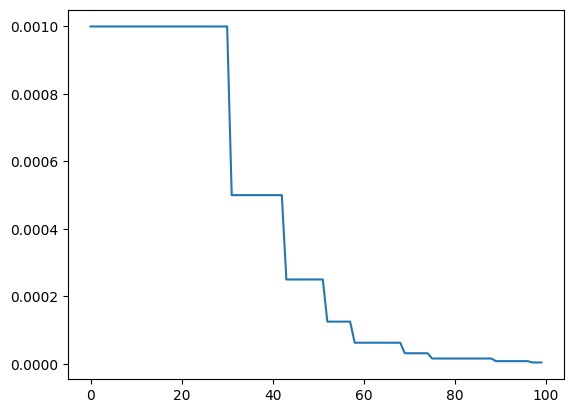

In [86]:
plt.plot(lr)

Plot Train Acc, loss

In [87]:
ep=[i for i in range(1, CFG['EPOCHS']+1)]

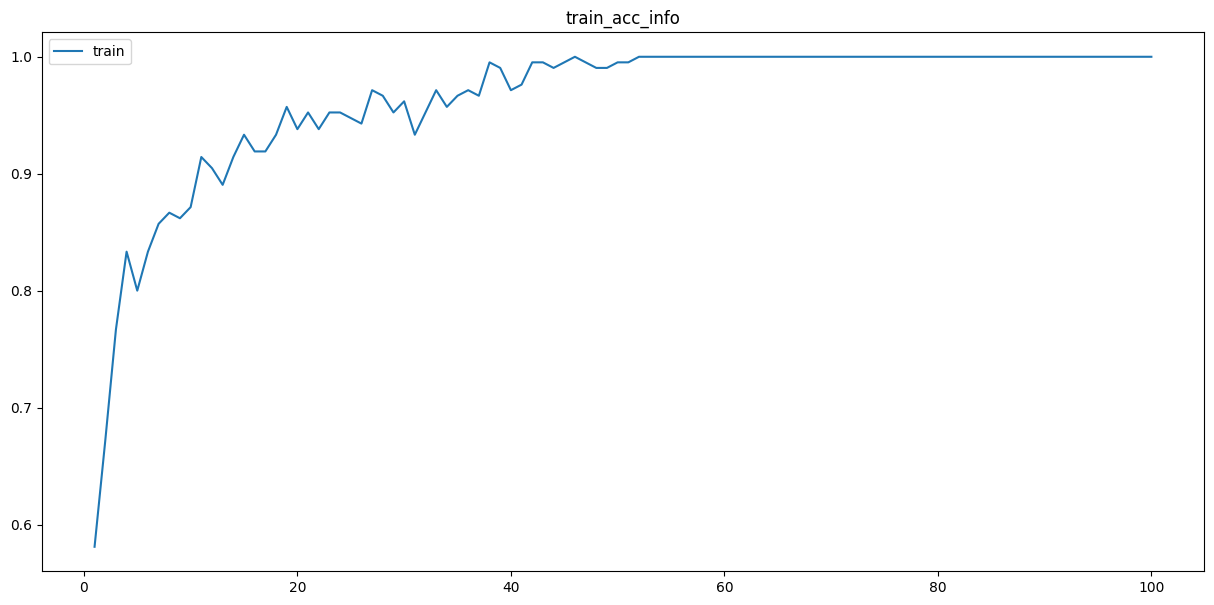

In [88]:
plt.figure(figsize=(15,7))
plt.title('train_acc_info')
plt.plot(ep, train_acc_info, label='train')
plt.legend()

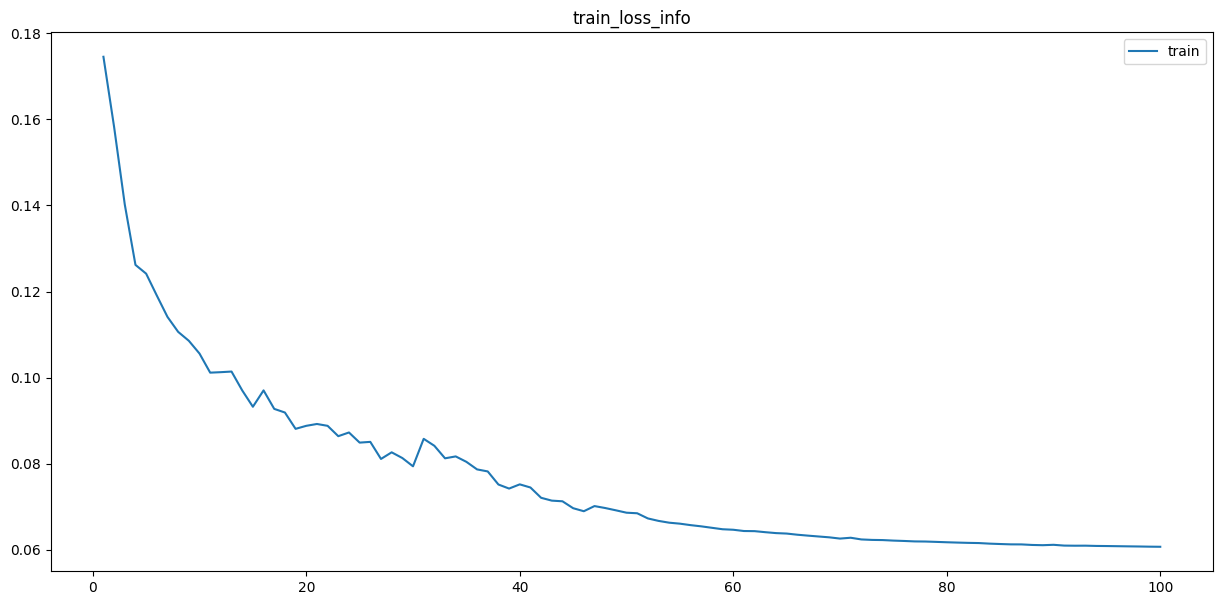

In [89]:
plt.figure(figsize=(15,7))
plt.title('train_loss_info')
plt.plot(ep, train_loss_info, label='train')
plt.legend()

Plot val Acc, loss

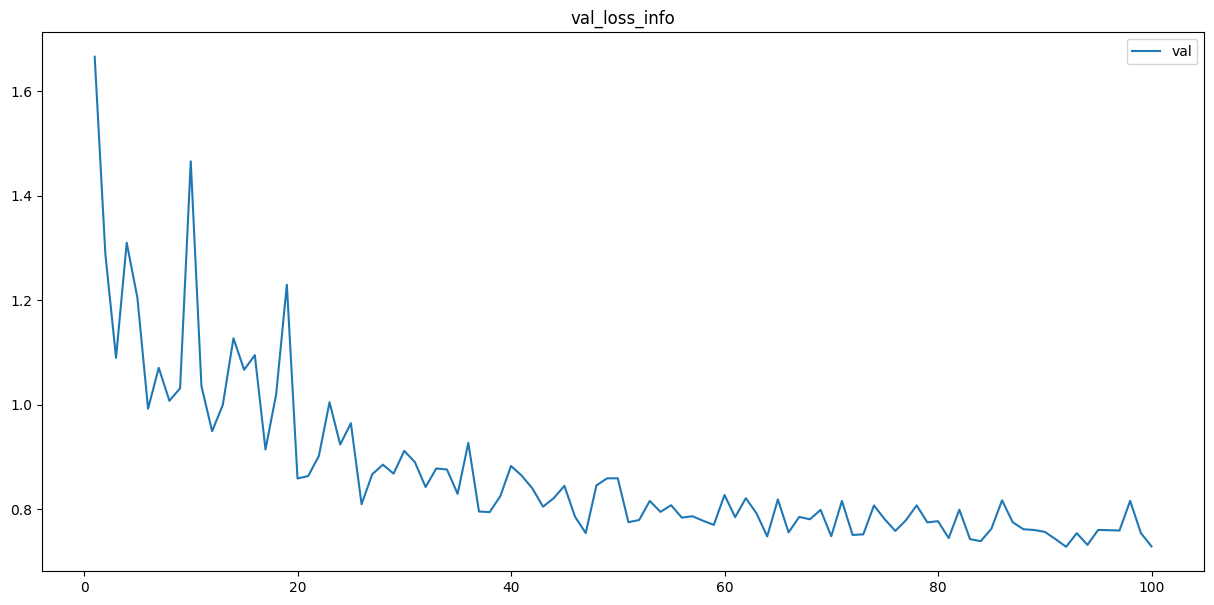

In [90]:
plt.figure(figsize=(15,7))
plt.title('val_loss_info')
plt.plot(ep,val_loss_info, label='val')
plt.legend()

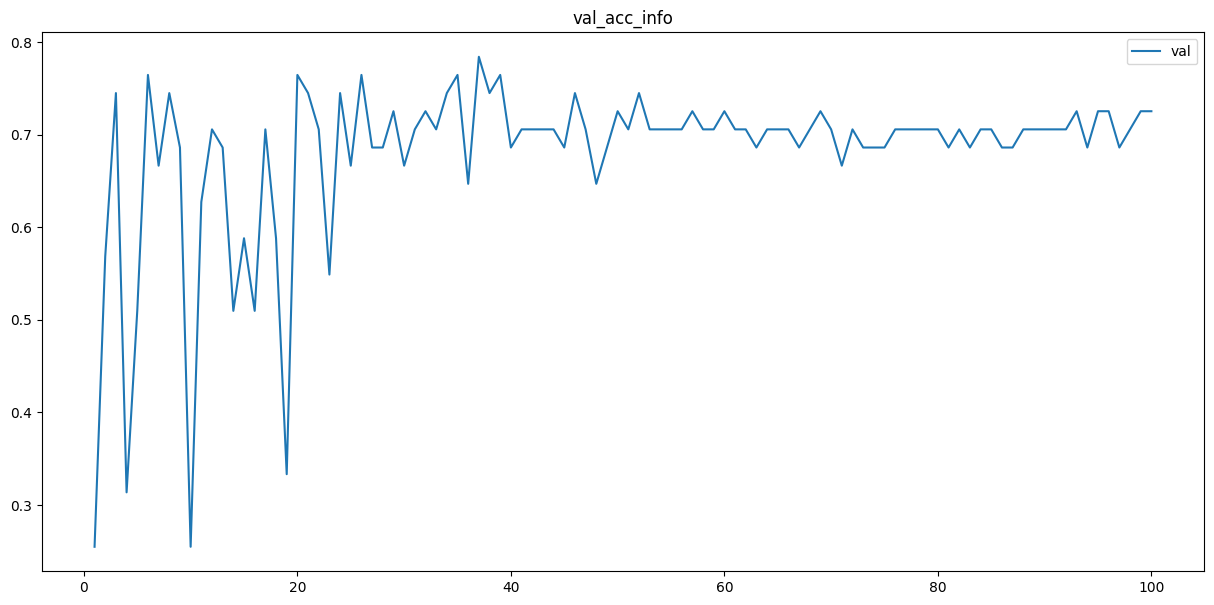

In [91]:
plt.figure(figsize=(15,7))
plt.title('val_acc_info')
plt.plot(ep,val_acc_info, label='val')
plt.legend()

# 13. Save Model

In [92]:
PATH='C:\\Users\\PC00\\Desktop\\ASD_data\\model\\T2\\'

In [93]:
torch.save(model, PATH+'model.pt') #전체 모델 저장
torch.save(model.state_dict(), PATH+'model_state_dict.pt') #모델 객체의 state_dict 저장
torch.save({
    'model':model.state_dict(),
    'optimizer':optimizer.state_dict()
}, PATH+'all.tar') #여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar 값 저장 가능

# 14. Test

In [94]:
model=torch.load(PATH+'model.pt') #전체 모델을 통째로 불러옴
model.load_state_dict(torch.load(PATH+'model_state_dict.pt')) #state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

model.to(device)

ResNet18(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias

In [95]:
#sensitivity
#양성인 것중에 양성으로 판별

#specificity
#음성인 것중에 음성으로 판별

def true_positive(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==1 and p[i]==1:
            cnt+=1
            
    return cnt


def true_negative(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==0 and p[i]==0:
            cnt+=1
    
    return cnt

In [96]:
def test_loop(dataloader,model, loss_fn, test_asd, test_tc):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()
    
    test_loss, correct=0,0
    
    TP,TN=0,0
    
    with torch.no_grad():
        for X,y in dataloader:
            X=Variable(X.to(device).float())
            y=Variable(y.to(device).float())
            
            pred=model(X)
            
            #loss
            test_loss+=loss_fn(pred, y).item()
            #accuracy
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            print(f"Pred : {pred.argmax(1)}")
            print(f"True : {y.argmax(1)}")
            print()
            TP+=true_positive(pred.argmax(1), y.argmax(1))
            TN+=true_negative(pred.argmax(1), y.argmax(1))
    
    FN=test_asd-TP
    FP=test_tc-TN
    test_loss/=num_batches
    correct/=size
    
    print(f"Test Error\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")
    print(f"True Positive : {TP}\nTrue Negative : {TN}\nFalse Positive : {FP}\nFalse Negative : {FN}\n")
    return (TP/(TP+FN))*100, (TN/(FP+TN))*100, (TP/(TP+FP))*100, (TN/(FN+TN))*100

In [97]:
test_asd=25
test_tc=19

start=time.time()

sensitivity, specificity, PPV, NPV=test_loop(test_dataloader ,model, loss_fn, test_asd, test_tc)

end=time.time()

print(f"Test 걸린 시간 : {(end-start)//60} 분 {(end-start)%60:.1f} 초")

Pred : tensor([0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
True : tensor([1, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')

Pred : tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
True : tensor([1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')

Pred : tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
True : tensor([1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')

Pred : tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
True : tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')

Pred : tensor([1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
True : tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')

Pred : tensor([1, 1, 1, 1], device='cuda:0')
True : tensor([1, 0, 0, 1], device='cuda:0')

Test Error
 Accuracy : 52.3%, Avg Loss : 0.777433

True Positive : 20
True Negative : 3
False Positive : 16
False Negative : 5

Test 걸린 시간 : 0.0 분 12.8 초


In [98]:
print(f"Sensitivity : {sensitivity:.3f}%")
print(f"Specificity : {specificity:.3f}%")
print(f"PPV : {PPV:.3f}%")
print(f"NPV : {NPV:.3f}%")

Sensitivity : 80.000%
Specificity : 15.789%
PPV : 55.556%
NPV : 37.500%
